In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def read_data(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    nodes = []
    quantities = {}

    for request in root.findall('requests/request'):
        children = list(request)
        quantities[request.attrib['node']] = float(children[0].text)

    for node in root.findall('network/nodes/node'):
        id = node.attrib['id']
        cx = float(node[0].text)
        cy = float(node[1].text)
        quantity = 0
        if(id != '1'):
            quantity = quantities[node.attrib['id']]

        nodes.append({
            'id': id,
            'cx': cx,
            'cy': cy,
            'quantity': quantity
            })
            
    return {
        'depot': nodes[0],
        'orders': np.array(nodes[1:]),
        'num_orders': len(nodes) - 1,
        'max_capacity': float(root.findtext('fleet/vehicle_profile/capacity'))
    }

filename = 'A-n32-k05.xml'
data = read_data('../Datasets/augerat-1995-set-a/' + filename)
orders_dictionary = {}
for order in data['orders']:
    orders_dictionary[order['id']] = order

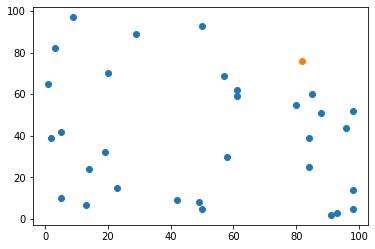

In [3]:
x = [order['cx'] for order in data['orders']]
y = [order['cy'] for order in data['orders']]

plt.scatter(x,y)
plt.scatter(data['depot']['cx'],data['depot']['cy'])
plt.show()

In [4]:
class HeuristicSolver:
    def __init__(self, depot, orders, num_orders, num_vehicles = 5, vehicle_max_capacity = 100):
        self.depot = depot
        self.orders = orders
        self.orders_left = orders
        self.num_orders = num_orders
        self.num_vehicles = num_vehicles
        self.vehicle_max_capacity = vehicle_max_capacity
    
    def generate_routes(self):
        self.routes = []
        self.total_distance = 0
        self.__calc_route(-1, 0, [], 0, 1)
        return self.routes, self.total_distance

    def __calc_route(self, cur_order_index, cur_capacity, cur_route, cur_dist, cur_vehicle):
        cur_order = None
        if cur_order_index >= 0:
            cur_order = self.orders_left[cur_order_index]

        if(cur_vehicle > self.num_vehicles):
            return

        if cur_order:
            if cur_capacity + cur_order['quantity'] > self.vehicle_max_capacity :
                if len(cur_route) > 0:
                    self.routes.append(cur_route)
                    self.total_distance += cur_dist
                self.__calc_route(-1, 0, [], 0, cur_vehicle+1)
                return
            else:
                self.orders_left = np.delete(self.orders_left, cur_order_index)

        index, dist = self.__findClosestNode(cur_order if cur_order else self.depot)
        if index == -1 :
            if len(cur_route) > 0:
                cur_dist += self.__distance(cur_order, self.depot)
                self.total_distance += cur_dist
                self.routes.append(cur_route)
            return

        if cur_order:
            cur_capacity += cur_order['quantity']
            cur_route.append(cur_order['id'])
        cur_dist += dist

        self.__calc_route(index, cur_capacity, cur_route, cur_dist, cur_vehicle)
 
    def __findClosestNode(self, cur_order):
        min_dist = float('inf')
        min_dist_index = -1; 
        for i in range(len(self.orders_left)):
            if(self.orders_left[i]['id'] == cur_order['id']):
                continue
            cur_dist = self.__distance(cur_order, self.orders_left[i])
            if(cur_dist < min_dist):
                min_dist = cur_dist
                min_dist_index = i
        return min_dist_index, min_dist
            
    def __distance(self, a, b):
        return math.sqrt((a['cx'] - b['cx'])**2 + (a['cy'] - b['cy'])**2)

In [5]:
class RoutesPlotter:
    def __init__(self, depot, routes, title):
        self.routes = routes
        self.depot = depot
        self.title = title
    
    def plot(self):
        for route in self.routes:
            x = [self.depot['cx']]
            y = [self.depot['cy']]
            # print(route[0]['cx'])
            x.extend(list(orders_dictionary[str(id)]['cx'] for id in route))
            y.extend(list(orders_dictionary[str(id)]['cy'] for id in route))
            x.append(self.depot['cx'])
            y.append(self.depot['cy'])
            plt.plot(x, y)
            plt.scatter(x, y)
        plt.scatter(self.depot['cx'],self.depot['cy'])
        plt.title(self.title)
        plt.show()

In [6]:
class DNA:
    def __init__(self, genes):
        self.genes = genes

In [7]:
class EucludianFitnessClaculator:
    def __init__(self, depot, orders_dictionary, num_orders):
        self.depot = depot
        self.orders = orders_dictionary
        self.num_orders = num_orders

    def fitness(self, dna):
        last_stop = self.depot
        fitness = 0
        for gene in dna:
            if gene <= self.num_orders + 1:
                cur_stop = self.orders[str(gene)]
                fitness +=  EucludianFitnessClaculator.__distance(last_stop, cur_stop)
                last_stop = cur_stop
            else:
                fitness +=  EucludianFitnessClaculator.__distance(last_stop, self.depot)
                last_stop = self.depot
            # print(fitness)

                
        fitness += EucludianFitnessClaculator.__distance(last_stop, self.depot)
        return fitness

    def __distance(a, b):
        return math.sqrt((a['cx'] - b['cx'])**2 + (a['cy'] - b['cy'])**2)


In [39]:
class GeneticAlgorithmSolver:
    def __init__(self, depot, orders_dictionary, num_orders, num_vehicles = 5, 
        vehicle_max_capacity = 100, max_iter = 1000, mutaion_propability = 0.01, population_size = 1000):
        self.depot = depot
        self.orders = orders_dictionary
        self.num_orders = num_orders
        self.num_vehicles = num_vehicles
        self.vehicle_max_capacity = vehicle_max_capacity
        self.max_iter = max_iter
        self.mutaion_propability = mutaion_propability
        self.fitness_calculator = EucludianFitnessClaculator(self.depot, self.orders, self.num_orders)
        self.population_size = population_size
        self.best_solution = [math.inf, []]
        self.history = []
    
    def generate_random_population(self):
        cur_orders = self.orders.copy()
        routes = []

        for _ in range(self.num_vehicles):
            routes.append([])

        while len(cur_orders) != 0:
            vehicle = random.randint(0,self.num_vehicles-1)
            order_id, _ = random.choice(list(cur_orders.items()))
            del cur_orders[order_id]
            routes[vehicle].append(int(order_id))
        
        population = []
        cur_vehicle = self.num_orders + 2
        for route in routes:
            population += route
            population.append(cur_vehicle)
            cur_vehicle += 1
        population.pop()
        
        return population

    def checkCapacityConstraint(self, dna):
        curCapacity = 0
        for gene in dna:
            if gene <= self.num_orders + 1:
                curCapacity += orders_dictionary[str(gene)]['quantity']
            else:
                curCapacity = 0
            if curCapacity > self.vehicle_max_capacity:
                return False
        if curCapacity > self.vehicle_max_capacity:
                return False
        return True

    def fit(self):
        population = []
        while len(population) < self.population_size:
            dna = self.generate_random_population()
            if self.checkCapacityConstraint(dna):
                population.append((self.fitness_calculator.fitness(dna), dna))

        top = self.generation_evolution(population)
        return top
    
    def generation_evolution(self, population, generation = 1):
        population.sort()

        print('Generation #' + str(generation) + ', fitness: ' + str(population[0][0]))

        if generation >= self.max_iter:
            return
            
        best_solution = population[:150]

        self.history.append(best_solution[0])

        if self.best_solution[0] > best_solution[0][0]:
            self.best_solution = best_solution[0]


        new_population = []
        while len(new_population) < self.population_size:
            parent1 = self.mutation(random.choice(best_solution)[1])
            parent2 = self.mutation(random.choice(best_solution)[1])
            child1, child2 = self.crossover(parent1, parent2)
            if self.checkCapacityConstraint(child1):
                new_population.append((self.fitness_calculator.fitness(child1), child1))
            if self.checkCapacityConstraint(child2):
                new_population.append((self.fitness_calculator.fitness(child2), child2))
        self.generation_evolution(new_population, generation + 1)

    def mutation(self, chromosome):
            
        def inversion_mutation(chromosome_aux):
            chromosome = chromosome_aux
            
            index1 = random.randrange(0,len(chromosome))
            index2 = random.randrange(index1,len(chromosome))
            
            chromosome_mid = chromosome[index1:index2]
            chromosome_mid.reverse()
            
            chromosome_result = chromosome[0:index1] + chromosome_mid + chromosome[index2:]
            
            return chromosome_result
    
        aux = chromosome
        for _ in range(len(chromosome)):
            if random.random() < self.mutaion_propability :
                aux = inversion_mutation(chromosome)
        return aux

    def crossover(self,parent1, parent2):

        def process_gen_repeated(copy_child1,copy_child2):
            count1=0
            for gen1 in copy_child1[:pos]:
                repeat = 0
                repeat = copy_child1.count(gen1)
                if repeat > 1:#If need to fix repeated gen
                    count2=0
                    for gen2 in parent1[pos:]:#Choose next available gen
                        if gen2 not in copy_child1:
                            child1[count1] = parent1[pos:][count2]
                        count2+=1
                count1+=1

            count1=0
            for gen1 in copy_child2[:pos]:
                repeat = 0
                repeat = copy_child2.count(gen1)
                if repeat > 1:#If need to fix repeated gen
                    count2=0
                    for gen2 in parent2[pos:]:#Choose next available gen
                        if gen2 not in copy_child2:
                            child2[count1] = parent2[pos:][count2]
                        count2+=1
                count1+=1

            return [child1,child2]

        pos=random.randrange(1,len(parent1) - 1)
        child1 = parent1[:pos] + parent2[pos:] 
        child2 = parent2[:pos] + parent1[pos:] 
        
        return  process_gen_repeated(child1, child2)


In [43]:
def plot_solution(depot, solution, num_orders):
    routes = [[]]
    j = 0
    for i in range(len(solution[1])):
        if solution[1][i] <= num_orders:
            routes[j].append(solution[1][i])
        else:
            j += 1
            routes.append([])
    plotter = RoutesPlotter(depot, routes, solution[0])
    plotter.plot()

In [54]:
solver = GeneticAlgorithmSolver(data['depot'], orders_dictionary, data['num_orders'], max_iter=300, 
    mutaion_propability=0.25, population_size=1000)
# mutaion_propability best is 1 / number of descision variables ie 1 / 32

Generation #1, fitness: 1704.5658748153278
Generation #2, fitness: 1579.2295402658715
Generation #3, fitness: 1496.2965795927244
Generation #4, fitness: 1448.5401665804138
Generation #5, fitness: 1352.048634854778
Generation #6, fitness: 1348.2924731867677
Generation #7, fitness: 1309.4440669526928
Generation #8, fitness: 1239.186704475153
Generation #9, fitness: 1254.3358000783546
Generation #10, fitness: 1240.4136802368475
Generation #11, fitness: 1186.9218778878444
Generation #12, fitness: 1137.105439879274
Generation #13, fitness: 1089.7465464060485
Generation #14, fitness: 1081.0769075027677
Generation #15, fitness: 1053.4761448330046
Generation #16, fitness: 1019.593359736388
Generation #17, fitness: 1003.9175342458558
Generation #18, fitness: 986.9709533539502
Generation #19, fitness: 964.2411586343272
Generation #20, fitness: 937.640429658605
Generation #21, fitness: 915.8074151104404
Generation #22, fitness: 906.6707174010355
Generation #23, fitness: 906.6707174010355
Generati

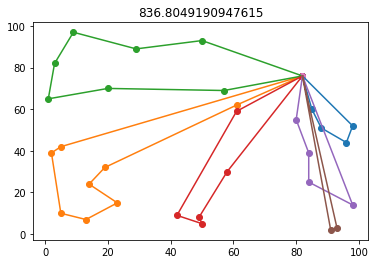

(836.8049190947615, [13, 2, 17, 31, 33, 25, 19, 9, 29, 5, 12, 10, 23, 34, 21, 6, 26, 11, 16, 30, 28, 35, 7, 4, 3, 24, 15, 36, 27, 8, 14, 22, 32, 18, 20])


In [55]:
solver.fit()
plot_solution(data['depot'], solver.best_solution, data['num_orders'])
print(solver.best_solution)

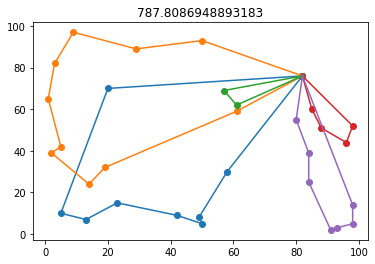

In [ ]:
# plotter = RoutesPlotter(data['depot'], [
#     [7, 4, 3, 24, 29, 5, 12, 30],
#     [15, 19, 9, 10, 23, 16, 11, 26, 6, 21],
#     [25, 28],
#     [31, 17, 2, 13],
#     [27, 8, 14, 18, 20, 32, 22]
# ], '787.8086948893183')
# plotter.plot()

In [ ]:
# **************************
# best version *************
# **************************
solver = GeneticAlgorithmSolver(data['depot'], orders_dictionary, data['num_orders'], max_iter=300, 
    mutaion_propability=0.25, population_size=1000)